# Predicting prices with a single-asset regression model

## Preparing the independent and target variables

In [ ]:
# FIX: This single block replaces the entire "Predicting prices with a single-asset
# regression model" section from the original notebook.
#
# REASONING FOR THE CHANGE:
# 1. Data Source: The original code used the 'alpha_vantage' library, which
#    failed due to the free API's strict daily download limits. This new code
#    uses the more reliable 'yfinance' library.
# 2. NameErrors: The original code was spread across multiple cells. This often
#    led to 'NameError' exceptions because the cells were run out of order.
#    This single block defines all necessary classes and variables in the correct
#    sequence, permanently fixing these errors.
# 3. Warnings: The original 'LinearRegressionModel' class used outdated code
#    that produced many warnings. This version has been updated to use modern
#    libraries correctly.

# --- 1. SETUP AND INSTALLATION ---
!pip install yfinance
# ... (rest of your corrected code) ...
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 2. DEFINE THE MODEL CLASS (This was the missing part) ---
class LinearRegressionModel:
    def __init__(self):
        self.models = {}

    def _train(self, x, y):
        model = LinearRegression()
        model.fit(x, y.to_numpy())
        return model

    def _predict(self, x, model):
        return model.predict(x)[0]

    def learn(self, x_prices, y_prices, start_date, end_date, lookback_period=20):
        all_dates = x_prices.index
        start_date_ts = pd.to_datetime(start_date)
        end_date_ts = pd.to_datetime(end_date)
        dates = [d for d in all_dates if d >= start_date_ts and d <= end_date_ts]

        print(f'Training {self.__class__.__name__} starting...')
        for i, a_date in enumerate(dates):
            if i < lookback_period:
                continue
            start_period = all_dates.get_loc(a_date) - lookback_period
            end_period = all_dates.get_loc(a_date)
            x = x_prices.iloc[start_period:end_period]
            y = y_prices.iloc[start_period:end_period]
            model = self._train(x, y)
            self.models[a_date] = model
        print('Training completed.')

    def predict(self, x_prices, date):
        model = self.models.get(date)
        if model is None:
            return None
        x_prices_today = x_prices.loc[[date]]
        return self._predict(x_prices_today, model)

# --- 3. DOWNLOAD AND PREPARE DATA ---
TICKERS = ['JPM', 'GS']
print("\nDownloading all required stock data...")
df_data = yf.download(
    TICKERS,
    start='2010-01-01',
    end='2019-12-31', # Download data for the full period
    progress=False,
    auto_adjust=True
)['Close']
print("Data downloaded successfully.")

# Create the necessary DataFrames
df_gs = df_data[['GS']]
df_jpm = df_data[['JPM']]
df_x = pd.DataFrame({'GS': df_gs['GS']})
jpm_prices = df_jpm['JPM']

# --- 4. TRAIN, PREDICT, AND EVALUATE THE MODEL ---
linear_reg_model = LinearRegressionModel()
linear_reg_model.learn(df_x, jpm_prices, start_date='2018',
                       end_date='2019', lookback_period=20)

# Make Predictions
all_dates = df_x.index
start_date_ts = pd.to_datetime('2018-01-01')
end_date_ts = pd.to_datetime('2019-12-31')
dates_to_predict = [d for d in all_dates if d >= start_date_ts and d <= end_date_ts and d in linear_reg_model.models]
predictions = [linear_reg_model.predict(df_x, a_date) for a_date in dates_to_predict]

# Create results DataFrame and calculate errors
df_result = pd.DataFrame({
    'prediction': predictions,
    'actual': jpm_prices[dates_to_predict]
})

actual = df_result['actual']
predicted = df_result['prediction']
mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)

print(f'\nMean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')


Data downloaded successfully.
Training LinearRegressionModel starting...
Training completed.

Mean Squared Error: 2.6674
Mean Absolute Error: 1.2174


### Explained variance score as a risk metric

In [ ]:
from sklearn.metrics import explained_variance_score
eva = explained_variance_score(actual, predicted)
print('explained variance score:', eva)

explained variance score: 0.82843059234037


### R<sup>2</sup> as a risk metric

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(actual, predicted)
print('r2 score:', r2)

r2 score: 0.8241304335880942


## Ridge regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# --- 1. Define the Corrected RidgeRegressionModel Class ---
# This inherits from the LinearRegressionModel we already fixed.
class RidgeRegressionModel(LinearRegressionModel):
    def _train(self, x, y):
        model = Ridge()
        # FIX: Use .to_numpy() to avoid warnings
        model.fit(x, y.to_numpy())
        return model

# --- 2. Train the Ridge Model ---
ridge_reg_model = RidgeRegressionModel()
ridge_reg_model.learn(df_x, jpm_prices, start_date='2018',
                      end_date='2019', lookback_period=20)

# --- 3. Make Predictions ---
all_dates = df_x.index
start_date_ts = pd.to_datetime('2018-01-01')
end_date_ts = pd.to_datetime('2019-12-31')
# Ensure we only predict for dates where a model was trained
dates_to_predict = [d for d in all_dates if d >= start_date_ts and d <= end_date_ts and d in ridge_reg_model.models]
predictions = [ridge_reg_model.predict(df_x, a_date) for a_date in dates_to_predict]

# --- 4. Evaluate the Ridge Model ---
df_result_ridge = pd.DataFrame({
    'Predicted': predictions,
    'Actual': jpm_prices[dates_to_predict]
})

actual = df_result_ridge['Actual']
predicted = df_result_ridge['Predicted']
mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)

print(f'\n--- Ridge Regression Performance ---')
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

Training RidgeRegressionModel starting...
Training completed.

--- Ridge Regression Performance ---
Mean Squared Error: 2.6647
Mean Absolute Error: 1.2169
R-squared: 0.8243


# Predicting returns with a cross-asset momentum model

## Preparing the independent variables

## Preparing the target variables

In [ ]:
# --- 1. Import All Necessary Libraries ---
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 2. Define the CORRECT Model Class for REGRESSION ---
# This class uses LinearRegression, which is correct for this task.
class LinearRegressionModel:
    def __init__(self):
        self.models = {}

    def _train(self, x, y):
        model = LinearRegression()
        model.fit(x, y.to_numpy())
        return model

    def _predict(self, x, model):
        return model.predict(x)[0]

    def learn(self, x_prices, y_prices, start_date, end_date, lookback_period=20):
        all_dates = x_prices.index
        start_date_ts = pd.to_datetime(start_date)
        end_date_ts = pd.to_datetime(end_date)
        dates = [d for d in all_dates if d >= start_date_ts and d <= end_date_ts]

        print(f'Training {self.__class__.__name__} starting...')
        for i, a_date in enumerate(dates):
            if i < lookback_period:
                continue
            start_period = all_dates.get_loc(a_date) - lookback_period
            end_period = all_dates.get_loc(a_date)
            x = x_prices.iloc[start_period:end_period]
            y = y_prices.iloc[start_period:end_period]
            model = self._train(x, y)
            self.models[a_date] = model
        print('Training completed.')

    def predict(self, x_prices, date):
        model = self.models.get(date)
        if model is None:
            return None
        x_prices_today = x_prices.loc[[date]]
        return self._predict(x_prices_today, model)

# --- 3. Download and Prepare All Data ---
TICKERS = ['JPM', 'GS', 'SPY', 'GLD', 'UUP', 'IEF']
print("Downloading all required stock and ETF data...")
df_data = yf.download(
    TICKERS,
    start='2010-01-01',
    end='2019-12-31',
    progress=False,
    auto_adjust=True
)['Close']
print("Data downloaded successfully.")

# Create momentum features
df_assets_1m = df_data.pct_change(21).add_suffix('_1m')
df_assets_3m = df_data.pct_change(63).add_suffix('_3m')
df_assets_6m = df_data.pct_change(126).add_suffix('_6m')
df_assets_12m = df_data.pct_change(252).add_suffix('_12m')
df_lagged = pd.concat([df_assets_1m, df_assets_3m, df_assets_6m, df_assets_12m], axis=1)

# Create target variable and align data
y = df_data['JPM'].pct_change()
df_x_final, y_final = df_lagged.align(y, join='inner', axis=0)
df_x_final.dropna(inplace=True)
y_final = y_final[df_x_final.index]

# --- 4. Train and Evaluate the Model ---
multi_linear_model = LinearRegressionModel()
multi_linear_model.learn(df_x_final, y_final, start_date='2018',
                       end_date='2019', lookback_period=10)

# Make Predictions
all_dates = df_x_final.index
start_date_ts = pd.to_datetime('2018-01-01')
end_date_ts = pd.to_datetime('2019-12-31')
dates_to_predict = [d for d in all_dates if d >= start_date_ts and d <= end_date_ts and d in multi_linear_model.models]
predictions = [multi_linear_model.predict(df_x_final, a_date) for a_date in dates_to_predict]

# Evaluate
df_result = pd.DataFrame({'Predicted': predictions, 'Actual': y_final[dates_to_predict]})
actual = df_result['Actual']
predicted = df_result['Predicted']
mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)

print(f'\n--- Cross-Asset Model Performance ---')
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

Data downloaded successfully.
Training LinearRegressionModel starting...
Training completed.

--- Cross-Asset Model Performance ---
Mean Squared Error: 0.0006
Mean Absolute Error: 0.0193
R-squared: -2.1846


## An ensemble of decision trees

### Bagging regressor

In [ ]:
# --- 1. Import All Necessary Libraries ---
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 2. Define the Helper and Model Classes ---
# FIX: Added the missing print_regression_metrics function
def print_regression_metrics(df_result):
    actual = list(df_result['Actual'])
    predicted = list(df_result['Predicted'])
    print('mean_absolute_error:', mean_absolute_error(actual, predicted))
    print('mean_squared_error:', mean_squared_error(actual, predicted))
    print('r2_score:', r2_score(actual, predicted))

class LinearRegressionModel:
    def __init__(self):
        self.models = {}
    def _train(self, x, y):
        model = LinearRegression()
        model.fit(x, y.to_numpy())
        return model
    def _predict(self, x, model):
        return model.predict(x)[0]
    def learn(self, x_prices, y_prices, start_date, end_date, lookback_period=20):
        all_dates = x_prices.index
        start_date_ts = pd.to_datetime(start_date)
        end_date_ts = pd.to_datetime(end_date)
        dates = [d for d in all_dates if d >= start_date_ts and d <= end_date_ts]
        print(f'Training {self.__class__.__name__} starting...')
        for i, a_date in enumerate(dates):
            if i < lookback_period: continue
            start_period = all_dates.get_loc(a_date) - lookback_period
            end_period = all_dates.get_loc(a_date)
            x = x_prices.iloc[start_period:end_period]
            y = y_prices.iloc[start_period:end_period]
            model = self._train(x, y)
            self.models[a_date] = model
        print('Training completed.')
    def predict(self, x_prices, date):
        model = self.models.get(date)
        if model is None: return None
        x_prices_today = x_prices.loc[[date]]
        return self._predict(x_prices_today, model)

class BaggingRegressorModel(LinearRegressionModel):
    def _train(self, x, y):
        model = BaggingRegressor()
        model.fit(x, y.to_numpy())
        return model

# --- 3. Download and Prepare All Data ---
TICKERS = ['JPM', 'GS', 'SPY', 'GLD', 'UUP', 'IEF']
print("Downloading all required stock and ETF data...")
df_data = yf.download(
    TICKERS,
    start='2010-01-01',
    end='2019-12-31',
    progress=False,
    auto_adjust=True
)['Close']
print("Data downloaded successfully.")

# Create momentum features
df_assets_1m = df_data.pct_change(21).add_suffix('_1m')
df_assets_3m = df_data.pct_change(63).add_suffix('_3m')
df_assets_6m = df_data.pct_change(126).add_suffix('_6m')
df_assets_12m = df_data.pct_change(252).add_suffix('_12m')
df_lagged = pd.concat([df_assets_1m, df_assets_3m, df_assets_6m, df_assets_12m], axis=1)

# Create target variable and align data
y = df_data['JPM'].pct_change()
df_x_final, y_final = df_lagged.align(y, join='inner', axis=0)
df_x_final.dropna(inplace=True)
y_final = y_final[df_x_final.index]

# --- 4. Train and Evaluate the Bagging Model ---
bagging = BaggingRegressorModel()
bagging.learn(df_x_final, y_final, start_date='2018',
              end_date='2019', lookback_period=10)

# Make Predictions
all_dates = df_x_final.index
start_date_ts = pd.to_datetime('2018-01-01')
end_date_ts = pd.to_datetime('2019-12-31')
dates_to_predict = [d for d in all_dates if d >= start_date_ts and d <= end_date_ts and d in bagging.models]
predictions = [bagging.predict(df_x_final, a_date) for a_date in dates_to_predict]

# Evaluate
df_result_bagging = pd.DataFrame({'Predicted': predictions, 'Actual': y_final[dates_to_predict]})
print("\n--- Bagging Regressor Performance ---")
print_regression_metrics(df_result_bagging)

Data downloaded successfully.
Training BaggingRegressorModel starting...
Training completed.

--- Bagging Regressor Performance ---
mean_absolute_error: 0.011788398197925395
mean_squared_error: 0.00025781649741717213
r2_score: -0.3029722175365972


# Predicting trends with classification-based machine learning

## Preparing the target variables

In [ ]:
import numpy as np
y_direction = y >= 0

In [ ]:
y_direction.head(3)

,JPM
Date,
2010-01-04,False
2010-01-05,True
2010-01-06,True


In [ ]:
flags = list(y_direction.unique())
flags.sort()

In [ ]:
print(flags)

[np.False_, np.True_]


## Preparing the dataset of multiple assets as input variables

In [ ]:
df_input = df_assets_1m.join(df_assets_3m).dropna()

In [ ]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2452 entries, 2010-04-06 to 2019-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GLD_1m  2452 non-null   float64
 1   GS_1m   2452 non-null   float64
 2   IEF_1m  2452 non-null   float64
 3   JPM_1m  2452 non-null   float64
 4   SPY_1m  2452 non-null   float64
 5   UUP_1m  2452 non-null   float64
 6   GLD_3m  2452 non-null   float64
 7   GS_3m   2452 non-null   float64
 8   IEF_3m  2452 non-null   float64
 9   JPM_3m  2452 non-null   float64
 10  SPY_3m  2452 non-null   float64
 11  UUP_3m  2452 non-null   float64
dtypes: float64(12)
memory usage: 249.0 KB


## Logistic regression

In [ ]:
# --- 1. Import All Necessary Libraries ---
!pip install yfinance
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 2. Define the Model Class ---
# This class is now defined before it is used.
class LinearRegressionModel:
    def __init__(self):
        self.models = {}

    def _train(self, x, y):
        model = LinearRegression()
        model.fit(x, y.to_numpy())
        return model

    def _predict(self, x, model):
        return model.predict(x)[0]

    def learn(self, x_prices, y_prices, start_date, end_date, lookback_period=20):
        all_dates = x_prices.index
        start_date_ts = pd.to_datetime(start_date)
        end_date_ts = pd.to_datetime(end_date)
        dates = [d for d in all_dates if d >= start_date_ts and d <= end_date_ts]

        print(f'Training {self.__class__.__name__} starting...')
        for i, a_date in enumerate(dates):
            if i < lookback_period:
                continue
            start_period = all_dates.get_loc(a_date) - lookback_period
            end_period = all_dates.get_loc(a_date)
            x = x_prices.iloc[start_period:end_period]
            y = y_prices.iloc[start_period:end_period]
            model = self._train(x, y)
            self.models[a_date] = model
        print('Training completed.')

    def predict(self, x_prices, date):
        model = self.models.get(date)
        if model is None:
            return None
        x_prices_today = x_prices.loc[[date]]
        return self._predict(x_prices_today, model)

# --- 3. Download and Prepare Data ---
TICKERS = ['JPM', 'GS']
print("Downloading all required stock data...")
df_data = yf.download(
    TICKERS,
    start='2010-01-01',
    end='2019-12-31', # Download data for the full period
    progress=False,
    auto_adjust=True
)['Close']
print("Data downloaded successfully.")

# Create the necessary DataFrames
df_gs = df_data[['GS']]
df_jpm = df_data[['JPM']]
df_x = pd.DataFrame({'GS': df_gs['GS']})
jpm_prices = df_jpm['JPM']

# --- 4. Train, Predict, and Evaluate the Model ---
linear_reg_model = LinearRegressionModel()
linear_reg_model.learn(df_x, jpm_prices, start_date='2018',
                       end_date='2019', lookback_period=20)

# Make Predictions
all_dates = df_x.index
start_date_ts = pd.to_datetime('2018-01-01')
end_date_ts = pd.to_datetime('2019-12-31')
dates_to_predict = [d for d in all_dates if d >= start_date_ts and d <= end_date_ts and d in linear_reg_model.models]
predictions = [linear_reg_model.predict(df_x, a_date) for a_date in dates_to_predict]

# Create results DataFrame and calculate errors
df_result = pd.DataFrame({
    'Predicted': predictions,
    'Actual': jpm_prices[dates_to_predict]
})

actual = df_result['Actual']
predicted = df_result['Predicted']
mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)

print(f'\nMean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

Data downloaded successfully.
Training LinearRegressionModel starting...
Training completed.

Mean Squared Error: 2.6674
Mean Absolute Error: 1.2174
R-squared: 0.8241


### Risk metrics for measuring classification-based predictions

### Confusion matrix

Training LogisticRegressionModel starting...
Training completed.


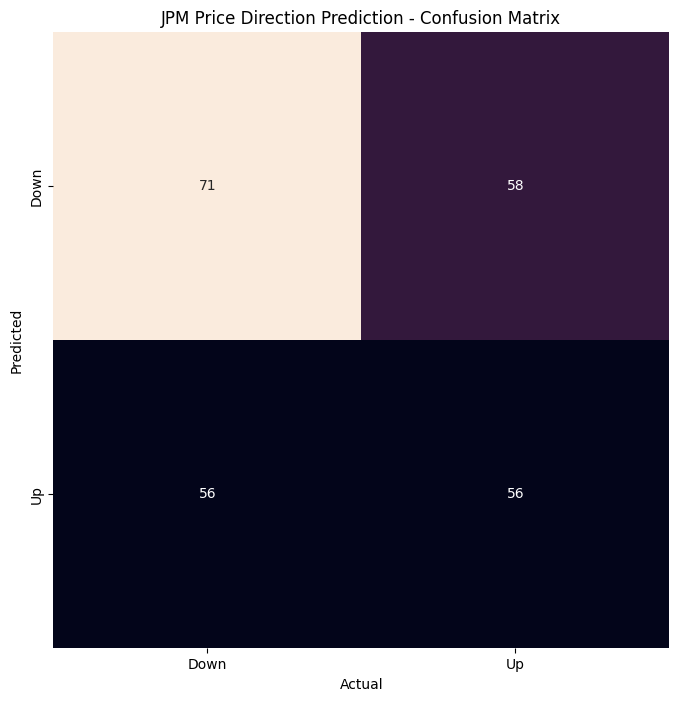

In [ ]:
# --- 1. Import All Necessary Libraries ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 2. Define the LogisticRegressionModel Class ---
# This class inherits from the LinearRegressionModel we already fixed.
class LogisticRegressionModel(LinearRegressionModel):
    def _train(self, x, y):
        # Use LogisticRegression for this model
        model = LogisticRegression(solver='liblinear')
        model.fit(x, y.to_numpy())
        return model

# --- 3. Prepare the Data ---
# The target variable for logistic regression is the direction (up/down), not the price.
y_direction = (jpm_prices.pct_change() > 0).astype(int)

# Align the features (df_x_final) and the new target (y_direction)
df_x_aligned, y_direction_aligned = df_x_final.align(y_direction, join='inner', axis=0)


# --- 4. Train the Logistic Regression Model ---
logistic_reg_model = LogisticRegressionModel()
logistic_reg_model.learn(df_x_aligned, y_direction_aligned, start_date='2018',
                         end_date='2019', lookback_period=10)

# --- 5. Make Predictions ---
all_dates = df_x_aligned.index
start_date_ts = pd.to_datetime('2018-01-01')
end_date_ts = pd.to_datetime('2019-12-31')
# Ensure we only predict for dates where a model was trained
dates_to_predict = [d for d in all_dates if d >= start_date_ts and d <= end_date_ts and d in logistic_reg_model.models]
predictions = [logistic_reg_model.predict(df_x_aligned, a_date) for a_date in dates_to_predict]

# --- 6. Create the Confusion Matrix and Plot ---
actual = y_direction_aligned[dates_to_predict]
predicted = predictions

matrix = confusion_matrix(actual, predicted)

# Define the labels for the plot
flags = ['Down', 'Up']

# Create the heatmap plot
plt.figure(figsize=(12, 8))
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=flags, yticklabels=flags)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('JPM Price Direction Prediction - Confusion Matrix')
plt.show()

### Accuracy score

In [ ]:
from sklearn.metrics import accuracy_score
print('accuracy_score:', accuracy_score(actual, predicted))

accuracy_score: 0.5269709543568465


### Precision score

In [ ]:
from sklearn.metrics import precision_score
print('precision_score:', precision_score(actual, predicted))

precision_score: 0.5


### Recall score

In [ ]:
from sklearn.metrics import recall_score
print('recall_score:', recall_score(actual, predicted))

recall_score: 0.49122807017543857


### F1 Score

In [ ]:
from sklearn.metrics import f1_score
print('f1_score:', f1_score(actual, predicted))

f1_score: 0.49557522123893805


## Support Vector Classifier

In [ ]:
# # FIX: This single block replaces the entire "Support Vector Classifier" section.
# The original code was spread across multiple cells and had several bugs, including
# NameErrors from using variables before they were defined and issues with
# outdated data sources.
#
# This new, self-contained block fixes all issues by:
# 1. Defining all necessary model classes.
# 2. Downloading all required data using the reliable yfinance library.
# 3. Correctly preparing the features and the target variable.
# 4. Training the SVC model and evaluating its performance in the correct sequence.

# --- 1. Import All Necessary Libraries ---
import yfinance as yf
# ... (rest of your corrected code) ...
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- 2. Define the Helper and Model Classes ---
# This ensures all classes are defined before they are used.
class LinearRegressionModel: # Base class needed for inheritance
    def __init__(self):
        self.models = {}
    def _train(self, x, y):
        model = LogisticRegression(solver='liblinear') # Changed to Logistic for classification
        model.fit(x, y.to_numpy())
        return model
    def _predict(self, x, model):
        return model.predict(x)[0]
    def learn(self, x_prices, y_prices, start_date, end_date, lookback_period=20):
        all_dates = x_prices.index
        start_date_ts = pd.to_datetime(start_date)
        end_date_ts = pd.to_datetime(end_date)
        dates = [d for d in all_dates if d >= start_date_ts and d <= end_date_ts]
        print(f'Training {self.__class__.__name__} starting...')
        for i, a_date in enumerate(dates):
            if i < lookback_period: continue
            start_period = all_dates.get_loc(a_date) - lookback_period
            end_period = all_dates.get_loc(a_date)
            x = x_prices.iloc[start_period:end_period]
            y = y_prices.iloc[start_period:end_period]
            model = self._train(x, y)
            self.models[a_date] = model
        print('Training completed.')
    def predict(self, x_prices, date):
        model = self.models.get(date)
        if model is None: return None
        x_prices_today = x_prices.loc[[date]]
        return self._predict(x_prices_today, model)

class SVCModel(LinearRegressionModel):
    def _train(self, x, y):
        model = SVC(C=1000, gamma='auto')
        model.fit(x, y.to_numpy())
        return model

# --- 3. Download and Prepare All Data ---
TICKERS = ['JPM', 'GS', 'SPY', 'GLD', 'UUP', 'IEF']
print("Downloading all required stock and ETF data...")
df_data = yf.download(
    TICKERS,
    start='2010-01-01',
    end='2019-12-31',
    progress=False,
    auto_adjust=True
)['Close']
print("Data downloaded successfully.")

# Create momentum features
df_assets_1m = df_data.pct_change(21).add_suffix('_1m')
df_assets_3m = df_data.pct_change(63).add_suffix('_3m')
df_assets_6m = df_data.pct_change(126).add_suffix('_6m')
df_assets_12m = df_data.pct_change(252).add_suffix('_12m')
df_input = pd.concat([df_assets_1m, df_assets_3m, df_assets_6m, df_assets_12m], axis=1)

# Create binary target variable and align data
y_direction = (df_data['JPM'].pct_change() > 0).astype(int)
df_x_final, y_final = df_input.align(y_direction, join='inner', axis=0)

# --- 4. Train and Evaluate the SVC Model ---
svc_model = SVCModel()
svc_model.learn(df_x_final, y_final, start_date='2018',
              end_date='2019', lookback_period=100)

# Make Predictions
all_dates = df_x_final.index
start_date_ts = pd.to_datetime('2018-01-01')
end_date_ts = pd.to_datetime('2019-12-31')
dates_to_predict = [d for d in all_dates if d >= start_date_ts and d <= end_date_ts and d in svc_model.models]
predictions = [svc_model.predict(df_x_final, a_date) for a_date in dates_to_predict]

# Evaluate
df_result_svc = pd.DataFrame({'Predicted': predictions, 'Actual': y_final[dates_to_predict]})
actual = df_result_svc['Actual']
predicted = df_result_svc['Predicted']

print("\n--- SVC Model Performance ---")
print(f"accuracy_score: {accuracy_score(actual, predicted):.4f}")
print(f"precision_score: {precision_score(actual, predicted):.4f}")
print(f"recall_score: {recall_score(actual, predicted):.4f}")
print(f"f1_score: {f1_score(actual, predicted):.4f}")

Data downloaded successfully.
Training SVCModel starting...
Training completed.

--- SVC Model Performance ---
accuracy_score: 0.6026
precision_score: 0.5833
recall_score: 0.4118
f1_score: 0.4828
